#### Import packages, set directories and parameters

In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shutil
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
import math
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
import collections
from scipy.stats import chi2, binom
from Comparative_Analysis import Alignment as alignfn
from Bio.Align.Applications import MuscleCommandline
import subprocess
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
project_dir = 'F:/Project_Data/mabR_Project/MTBC'
seq_dir = 'F:/Datasets/Other_Genomes/MTBC'
motif_loc = 'F:/Project_Data/mabR_Project/Second_MEME_Upstream_Output/meme.txt'
full_run = True
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'

In [5]:
tbc_seq_dict = {}
tbc_name_dict = {}
tbc_species_dirs = util.list_dirs(seq_dir)
for sdir in tbc_species_dirs:
    for genome_record in SeqIO.parse(seq_dir + '/' + sdir + '/sequence.gb', "genbank"):
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            tbc_name_dict[accession_ver] = genome_record.annotations['organism']
            full_sequence = str(genome_record.seq)
            tbc_seq_dict[accession_ver] = full_sequence
    

In [206]:
informal_names_dict = {'CP063804.2': 'M.orygis', 'CP016401.1':'M.caprae',  'LT708304.1': 'M.bovis', 'AL123456.3':'M.tb', 'LR882500.1': 'M.microti' , 'FR878060.1':'M.africanum', 'HE572590.1':'M.canettii'}

In [200]:
for k, v in tbc_seq_dict.items():
    print(k, tbc_name_dict[k], len(v))

CP063804.2 Mycobacterium orygis 4352140
CP016401.1 Mycobacterium tuberculosis variant caprae 4324961
LT708304.1 Mycobacterium tuberculosis variant bovis AF2122/97 4349904
AL123456.3 Mycobacterium tuberculosis H37Rv 4411532
LR882500.1 Mycobacterium tuberculosis variant microti 4384561
FR878060.1 Mycobacterium tuberculosis variant africanum GM041182 4389314
HE572590.1 Mycobacterium canettii CIPT 140010059 4482059


In [96]:
util.produce_fasta_file([[k,v] for k, v in tbc_seq_dict.items()], project_dir + '/tbc_sequences.faa')

100%|██████████| 7/7 [00:00<00:00, 10.88it/s]


In [97]:
blastfn.run_fimo(motif_loc, project_dir + '/tbc_sequences.faa' , project_dir + '/tbc_FIMO_Hits')

In [98]:
tbc_fimo_hits_df = pd.read_csv(project_dir + '/tbc_FIMO_Hits/fimo.tsv', sep='\t')

In [147]:
temp = []
for i, r in tbc_fimo_hits_df.iterrows():
    if '#' in r['motif_id'] or not(r['motif_alt_id'] == 'MEME-1') or r['q-value'] > 1e-3:
        continue
    start = int(r['start'])-100
    stop = int(r['stop'])+100
    if r['strand'] == 1:
        strand = '+'
    else:
        strand = '-'
    temp.append([r['sequence_name']+'@'+str(start)+'_'+str(stop)+'_'+strand, tbc_seq_dict[r['sequence_name']][start:stop]])

util.produce_fasta_file(temp, project_dir + '/mtbc_fimo_hits.faa')
print(len(temp))

100%|██████████| 1049/1049 [00:00<00:00, 59253.71it/s]

1049


In [148]:
if 1==1:
    blastfn.build_blast_db(project_dir, 'tbc_sequences.faa', 'MTBC', project_dir + '/BLAST/MTBC', 'nucl')
    shutil.copy(project_dir + '/mtbc_fimo_hits.faa', project_dir + '/BLAST/MTBC/mtbc_fimo_hits.faa')
    blastfn.run_blastn(project_dir + '/BLAST/MTBC', 'mtbc_fimo_hits.faa', 'MTBC', 'motif_mtbc_blast_hits.csv', e_value = 1e-1)

In [209]:
blast_results_df = pd.read_csv(project_dir + '/BLAST/MTBC/motif_mtbc_blast_hits.csv', header = None)
blast_results_df.columns = ['query_ref', 'target_ref', 'query_length', 'subject_length', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 
                         'query_start_alignment', 'query_end_alignment', 'target_start_alignment', 'target_end_alignment', 'e_value', 'bit_score']
blast_results_df = blast_results_df.loc[blast_results_df.groupby(['query_ref','target_ref'])['bit_score'].idxmax()]
for i, r in blast_results_df.iterrows():
    target_ref = r['target_ref'].split('@')[0]
    informal_target_ref = informal_names_dict[target_ref]
    query_ref = r['query_ref'].split('@')[0]
    blast_results_df.at[i,'query_organism'] = tbc_name_dict[query_ref]
    blast_results_df.at[i,'target_organism'] = tbc_name_dict[target_ref]
    temp = r['query_ref'].split('@')[1].split('_')
    query_start = int(temp[0])
    query_end = int(temp[1])
    target_start_alignment = int(r['target_start_alignment'])
    target_end_alignment = int(r['target_end_alignment'])
    query_start_alignment = int(r['query_start_alignment'])
    query_end_alignment = int(r['query_end_alignment'])
    full_target_alignment_start = target_start_alignment - query_start_alignment 
    full_target_alignment_end = target_end_alignment + 221- query_end_alignment
    blast_results_df.at[i, 'full_target_alignment_start'] =  full_target_alignment_start
    blast_results_df.at[i, 'full_target_alignment_end'] =  full_target_alignment_end
    blast_results_df.at[i, 'full_query_sequence'] =  tbc_seq_dict[query_ref][query_start:query_end]
    blast_results_df.at[i, 'full_target_sequence'] =  tbc_seq_dict[target_ref][full_target_alignment_start: full_target_alignment_end]
    blast_results_df.at[i, 'full_target_sequence_ref'] = target_ref + '_'+ str(full_target_alignment_start) + '_' + str(full_target_alignment_end)
    blast_results_df.at[i, 'informal_target_sequence_ref'] = informal_target_ref + '_'+ str(full_target_alignment_start) + '_' + str(full_target_alignment_end)

In [210]:
blast_results_df.to_csv(project_dir + '/processed_blast_results.csv')

In [211]:
temp_df = blast_results_df.query('query_end_alignment < 217')
distinct_clusters = []
regions_considered = []
for i, r in temp_df.iterrows():
    temp_df_2 = temp_df[temp_df['query_ref'] == r['query_ref']]
    matched = 0
    for j, s in temp_df_2.iterrows():
        for (species, start, stop) in regions_considered:
            if s['target_ref'] == species and s['full_target_alignment_start'] < stop and s['full_target_alignment_end'] > start:
                matched = 1
    if matched == 0:
        distinct_clusters.append(r['query_ref'])
        for j, s in temp_df_2.iterrows():
            regions_considered.append((s['target_ref'], s['full_target_alignment_start'], s['full_target_alignment_end'])) 

In [212]:
for ref in distinct_clusters:
    region_of_interest = blast_results_df.query('query_ref == @ref')
    temp = []
    for i, r in region_of_interest.iterrows():
        temp.append([r['informal_target_sequence_ref'],r['full_target_sequence']])
    util.produce_fasta_file(temp, project_dir + '/Regions_of_Interest/' + ref + '.faa')
    cline = MuscleCommandline(muscle_exe, input= project_dir + '/Regions_of_Interest/' + ref + '.faa', out = project_dir + '/Regions_of_Interest/' + ref + '_aligned.fasta')
    stdout, stderr = cline()

100%|██████████| 7/7 [00:00<?, ?it/s]


In [160]:
util.produce_fasta_file([['H37RV_2522064_2522460',tb_sequence[2522064:2522460]],['AF221297_2505723_2505831',bovis_sequence[2505623:2505931]]], project_dir + '/bovis_tb_difference.faa')

100%|██████████| 2/2 [00:00<?, ?it/s]


In [83]:
cline = MuscleCommandline(muscle_exe, input= project_dir + '/bovis_tb_difference.faa', out = project_dir + '/bovis_tb_alignment.fasta')
stdout, stderr = cline()

In [76]:
bovis_sequence[2505623:2505931]

'CGACGAGAAGATCGACCCGGCGCATACTCGCAGCAAGCTCACCGAGGCGCTGGCGCAGGCTCCGGCACGGCGCGGCCGCCACAAGAACATCCCGCTGTAGTTCTGACCGCGAGCCGCTCCTCGCATGCTCGAACGGTGCCTACCGACGCGCTAACAATTCTCGAGAAGGCCGGCGGGTTCGCCACCACCGCGCAATTGCTCACGGTCATGACCCGCCAACAGCTCGACGTCCAAGTGAAAAACGGCGGCCTCGTTCGCGTTTGGTACGGGGTCTACGCGGCACAAGAGCCGGACCTGTTGGGCCGCTT'

In [165]:
counts_df = blast_results_df.groupby(['query_ref']).size().reset_index()
counts_df=counts_df.rename(columns={0 : 'Count'}) 

#####  Analyse CRyPTIC 

In [7]:
if 1==0:
    variant_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/VARIANTS.csv') 
    with open(project_dir + '/variant_df.pkl', 'wb') as f:
        pickle.dump(variant_df[['UNIQUEID', 'VARIANT', 'MUTATION_TYPE', 'IS_NULL', 'IS_HET', 'IS_FILTER_PASS', 'IS_INDEL', 'REF', 'ALT', 'GENOME_INDEX']], f)   
    
    lineage_dict = {}
    genome_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/GENOMES.csv') 
    for i, r in genome_df.iterrows():
        lineage_dict[r['UNIQUEID']] = (r['MYKROBE_LINEAGE_NAME_1'], r['MYKROBE_LINEAGE_NAME_2'])
    with open(project_dir + '/lineage_dict.pkl', 'wb') as f:
        pickle.dump(lineage_dict, f) 

C:\Users\nicho\AppData\Local\Temp/ipykernel_16552/3028569424.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  variant_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/VARIANTS.csv')


In [259]:
with open(project_dir + '/variant_df.pkl', 'rb') as f:
        variant_df = pickle.load(f) 
genome_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/GENOMES.csv') 
gpi_genome_df = genome_df[genome_df['BELONGS_GPI']==True][['UNIQUEID']] 
print(len(gpi_genome_df))
gpi_variant_df = pd.merge(variant_df, gpi_genome_df, how='inner', on = 'UNIQUEID')
print(len(gpi_variant_df))
with open(project_dir + '/gpi_variant_df.pkl', 'wb') as f:
    pickle.dump(gpi_variant_df, f)    

C:\Users\nicho\AppData\Local\Temp/ipykernel_16552/3016038815.py:1: DtypeWarning: Columns (1,3,13,14,15,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  genome_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/GENOMES.csv')


15228
18159377


In [4]:
if 1 == 1:
    position_dict = {}
    variant_dict = {}
    #with open(project_dir + '/gpi_variant_df.pkl', 'rb') as f:
    with open(project_dir + '/variant_df.pkl', 'rb') as f:
        variant_df = pickle.load(f) 
        for i, r in variant_df.iterrows():
            if r['IS_NULL'] == False and r['IS_FILTER_PASS'] == True and r['IS_HET'] == False and r['IS_INDEL'] == True :
                
                if r['UNIQUEID'] in variant_dict:
                    variant_dict[r['UNIQUEID']].append((r['GENOME_INDEX'], r['REF'], r['ALT']))
                else:
                    variant_dict[r['UNIQUEID']] = [(r['GENOME_INDEX'], r['REF'], r['ALT'])]

                if r['GENOME_INDEX'] in position_dict:
                    position_dict[r['GENOME_INDEX']].append((r['UNIQUEID'], r['ALT']))
                else:
                    position_dict[r['GENOME_INDEX']] = [r['REF'], (r['UNIQUEID'], r['ALT'])]    # If first entry also include reference value for info
    with open(project_dir + '/variant_dict.pkl', 'wb') as f:
        pickle.dump(variant_dict, f) 
    with open(project_dir + '/position_dict.pkl', 'wb') as f:
        pickle.dump(position_dict, f) 
        

In [9]:
all_mite_ids = []
for k, v in position_dict.items():
    if len(v[0]) <= 5:
        for u in v[1:]:
            if len(u[1]) > 10 and 'cgagcagacg' in u[1]:
                all_mite_ids.append((k,u[0]))

In [13]:
if 1 == 1:
    phenotypes_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/UKMYC_PHENOTYPES.csv') 
    for i, r in phenotypes_df.iterrows():
        uniqueid = r['UNIQUEID']
        if uniqueid in [x[1] for x in all_mite_ids]:   #mite_ids or all_mite_ids for all
            phenotypes_df.at[i, 'MITE'] = 'Y'
            phenotypes_df.at[i,'INSERT_POS'] = ' '.join([str(x[0]) for x in all_mite_ids if x[1] == uniqueid])
        else:
            phenotypes_df.at[i, 'MITE'] = 'N'
            phenotypes_df.at[i,'INSERT_POS'] = ''

In [15]:
with open(project_dir + '/lineage_dict.pkl', 'rb') as f:
        lineage_dict = pickle.load(f) 

In [16]:
for i, r in phenotypes_df.iterrows():
    if r['UNIQUEID'] in lineage_dict:
        phenotypes_df.at[i, 'Lineage_1'] = lineage_dict[r['UNIQUEID']][0]
        phenotypes_df.at[i, 'Lineage_2'] = lineage_dict[r['UNIQUEID']][1]
phenotypes_df.to_csv(project_dir + '/phenotypes_mite_xref.csv')

In [22]:
temp = []
for (pos, uid) in all_mite_ids:
    if uid in lineage_dict:
        temp.append([pos, lineage_dict[uid][1]])
    else:
        temp.append([pos, ''])
                     

In [23]:
pd.DataFrame(temp, columns = ['pos','lineage']).to_csv(project_dir+'/mite_lineages.csv')

In [17]:
temp = []
for k, v in position_dict.items():
    if len(v[0]) >= 20  and 'cgagcagacg' in v[0]:
        ct = 0
        for u in v[1:]:
            if len(u[1]) < 3:
                ct+=1
        if ct > 0:
            print((k, v[0], len(v[0]), u[0], len(v)))

(3507998, 'tcggcgagcagacgtcaaagcccccgaatttcagtgaaatcgggggcttt', 50, 'site.02.subj.1149.lab.2014185089.iso.2', 2)
(456185, 'cgcgctagcacgggccggcgagcagacgcaaaatcgcacggtttgcggtt', 50, 'site.07.subj.11C4C391-4951-4B7A-953F-4CF9711E4DAD.lab.11C4C391-4951-4B7A-953F-4CF9711E4DAD.iso.1', 143)
(2751594, 'tgcgcgagcagacgcaaaagctcccaaatccgaccggatttgggagcttt', 50, 'site.24.subj.PT-17.lab.1999-372.iso.1', 2)
(234447, 'ccgagcagacgcagaatcgcccatttggtatcccaaatgggcgattctgc', 50, 'site.06.subj.06TB_0319.lab.06MIL0910.iso.1', 119)
(663387, 'ggcgcgagcagacgcagaatcgcacaaaatcagcgattttgatgcgattc', 50, 'site.03.subj.6760-13_LIB3069.lab.6760-13_LIB3069.iso.1', 80)
(1568035, 'agcgtcgagggcgcgagcagacgcagaatcgcacgcggaaaggcttccgc', 50, 'site.06.subj.06TB_0933.lab.06MIL1928.iso.1', 137)
(234432, 'gcccgccgccatccgccgagcagacgcagaatcgcccatttggtatccca', 50, 'site.ENA.subj.SAMN03648910.lab.1.iso.1', 4)
(558812, 'agtctgccgagcagacgcaaaagcacccttttgcggcgcaaaagtggcgc', 50, 'site.06.subj.06TB_0318.lab.06MIL0909.iso.1', 45)
(1133247

In [6]:
for k, v in position_dict.items():
    if len(v[0]) <= 5:
        ct = 0
        for u in v[1:]:
            if len(u[1]) > 20 and 'cgagcagacg' in (u[1]):
                ct +=1
        if ct > 0:
            print(k, v[1], len(v[1][1]), ct)

3423249 ('site.02.subj.1005.lab.2013182022.iso.2', 'cgcgagcagacgcagaatcgcccaaaatccaagattttgaggcgattctg') 50 44736
2352065 ('site.05.subj.LI2088309.lab.14892_2_22.iso.1', 'cctcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtg') 50 23793
2352071 ('site.24.subj.PT-87.lab.2019-273.iso.1', 'ctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcgggg') 50 123
4088249 ('site.ENA.subj.SAMN03648329.lab.1.iso.1', 'g') 1 1
2352062 ('site.ENA.subj.SAMN08708491.lab.1.iso.1', 'cgtctg') 6 1
234431 ('site.ENA.subj.SAMEA2040565.lab.1.iso.1', 't') 1 1
3423250 ('site.ENA.subj.SAMEA104153440.lab.1.iso.1', 'g') 1 1
2352067 ('site.ENA.subj.SAMEA104390504.lab.1.iso.1', 'tcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtc') 50 1
2352070 ('site.ENA.subj.SAMN06473197.lab.1.iso.1', 'cctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcggg') 50 1
2352063 ('site.ENA.subj.SAMN03648436.lab.1.iso.1', 'ctcctcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcg') 50 2
2352069 ('site.ENA.subj.SAMN06209904.lab.1.iso.1', 'gcctgggctggcgagcagacgcaaaa

<AxesSubplot:ylabel='Count'>

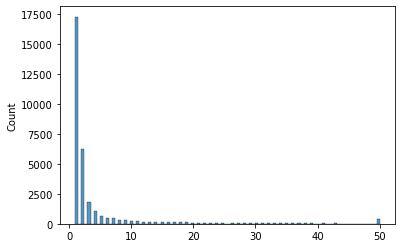

In [263]:
temp = []
for k, v in position_dict.items():
    temp.append(len(v[1][1]))
sns.histplot(temp, bins = 100)

In [230]:
mite_ids = []
mite_subjids = []
for i, r in phenotypes_df.iterrows():
    if r['MITE'] == 'Y':
        mite_ids.append(r['UNIQUEID'])
        mite_subjids.append(r['UNIQUEID'].split('.')[3])
mite_ids = list(set(mite_ids))
mite_subjids = list(set(mite_subjids))

In [197]:
UKMYC_PLATES=pd.read_csv('F:/Datasets/CRYPTIC_DATA/UKMYC_PLATES.csv.gz')

In [206]:
mite_plates = UKMYC_PLATES[UKMYC_PLATES['UNIQUEID'].isin(mite_ids)]

In [218]:
mite_plates.to_csv(project_dir + "/mite_plates.csv")


In [253]:
SAMPLES=pd.read_csv('F:/Datasets/CRYPTIC_DATA/SAMPLES.csv.gz')
SUBJECTS=pd.read_csv('F:/Datasets/CRYPTIC_DATA/SUBJECTS.csv.gz')
DST_SAMPLES=pd.read_csv('F:/Datasets/CRYPTIC_DATA/DST_SAMPLES.csv')

In [254]:
SUBJECTS

,SITEID,SUBJID,GENDER,COUNTRY_OF_ORIGIN
0,2,0958,male,NaN
1,2,0823,unknown,NaN
2,2,0359,unknown,CHN
3,2,0224,male,CHN
4,2,0870,male,NaN
...,...,...,...,...
15494,10,YA00023527,male,NaN
15495,10,YA00038868,male,NaN
15496,10,YA00038857,male,NaN
15497,10,YA00038867,male,NaN


In [233]:
mite_samples = SAMPLES[SAMPLES['SUBJID'].isin(mite_subjids)]

In [234]:
mite_samples

,SITEID,SUBJID,LABID,COUNTRY_WHERE_SAMPLE_TAKEN,REGION,COLLECTION_DATE,ISOLATE_COLLECTED_PROSPECTIVELY,ANATOMICAL_ORIGIN,SMEAR_RESULT,WGS_SEQUENCING_PLATFORM,...,HAIN_FL,HAIN_AM,HAIN_ETH,SMOKER,INJECT_DRUG_USER,IS_HOMELESS,IS_IMPRISONED,HIV,DIABETES,WHO_OUTCOME


In [251]:
DST_SAMPLES[DST_SAMPLES['UNIQUEID'].isin(mite_ids)]

,UNIQUEID,SOURCE,COUNTRY_CODE,NUMBER_DST,OTHER_METADATA_JSON,MYKROBE_LINEAGE_NAME_1,MYKROBE_LINEAGE_NAME_2
23225,site.01.subj.DR0011.lab.DR0011.iso.1,CRyPTIC,USA,12,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 2,lineage2.2
23227,site.01.subj.DR0018.lab.DR0018.iso.1,CRyPTIC,USA,12,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 2,lineage2.2
23229,site.01.subj.DR0030.lab.DR0030.iso.1,CRyPTIC,USA,12,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 2,lineage2.2.7
23230,site.01.subj.DR0031.lab.DR0031.iso.1,CRyPTIC,USA,9,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 4,lineage4.3.3
23231,site.01.subj.DR0036.lab.DR0036.iso.1,CRyPTIC,USA,12,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 2,lineage2.2
...,...,...,...,...,...,...,...
23357,site.01.subj.DR0724.lab.DR0724.iso.1,CRyPTIC,USA,13,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 4,lineage4.3.3
23358,site.01.subj.DR0725.lab.DR0725.iso.1,CRyPTIC,USA,11,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 2,lineage2.2
28750,site.06.subj.2194_14.lab.06MIL0459.iso.1,CRyPTIC,NaN,14,"{""MORE_DATA_IN_CRYPTIC_TABLES"": true, ""PLATEDE...",Lineage 3,lineage3
48640,site.06.subj.1967_14.lab.06MIL0352.iso.1,NEJM2018,PAK,19,"{'SRA': 'ERR2510555', 'GUID': '35f4f1ff-5bf0-4...",Lineage 3,lineage3


In [282]:
df_sheet_index = pd.read_excel('F:/Datasets/Data_From_Publications/WHO-UCN-GTB-PCI-2021.7-eng.xlsx', sheet_name='Genome_indices')
for i, r in df_sheet_index.iterrows():
    if len(r['alt_nt']) > 20 and len(r['ref_nt']) < 3:
        print(r['alt_nt'])

cacaaggacgcacatgacagg
acgccgccgcccatgcggtcgaaactag
caccccgtccacgatgacattcgagatcgccagg
acgacttctgcgagggtggctcgctggc
aagcgcgcgaagcgtcggcgtg
gcgacacgccgcctcaggctt
tgtgggggcactcgggggcggcgcccccgagg
gcccaacctggtagcggcggcgttggcgcgcgggctggc
caggcgctgtacacggccgcct
ctcggcgagtagccctcgtcgtagtt
tcgcattaaccgacgggtcggcccaggctgtcggggcgggaag
cgacgggtcggcccaggctgtcggggcgggaagcgcattaacc
cgtcgtgagcccgctcgccttt
ctcggcgcgcccccgcacgatctca


NameError: name 'accession_dir' is not defined